In [1]:
!pip install statsmodels==0.13.2
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import json

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
df_weather_all = pd.read_csv("weather.csv") #csv file containing the weather data
ovid_data_all = pd.read_csv("owid-covid-data.csv") #data with stringency index
positive_tests = pd.read_csv("data/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", sep=";") #region, date, confirmed cases (positive tests)

#filter the data, obtain only the weather data regarding Denmark and get only two significant columns: date, stringency index (data is not country wide, not regional)
ovid_denmark = ovid_data_all.loc[ovid_data_all['location'] == "Denmark"][['date', 'stringency_index']] 

#obtain the weather data for Denmark, regions (ISO3166) starting with DK
dk_weather = df_weather_all.loc[df_weather_all["iso3166-2"].str.slice(stop=2)=="DK"] 

In [3]:
#dk_weather dataframe sanity check

print("dk_weather dataframe summary:")
print("Shape", dk_weather.shape) # no. of observations and variables
print("Any missing values (N/A)? -", dk_weather.isna().any().any(), "\n")
print("Mean - temperature above ground (before converting) in Kelvin:", dk_weather["TemperatureAboveGround"].mean())
dk_weather["TemperatureAboveGround"] = dk_weather["TemperatureAboveGround"] - 273.15 #convert the temperature from kelvins to celsius
print("Mean - temperature above ground (after converting) in Celsius:", dk_weather["TemperatureAboveGround"].mean())

dk_weather dataframe summary:
Shape (1845, 9)
Any missing values (N/A)? - False 

Mean - temperature above ground (before converting) in Kelvin: 282.5351285322493
Mean - temperature above ground (after converting) in Celsius: 9.385128532249345
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [4]:
#Summary statistics by region, groupby function dividing the regions into rows, showing the summary stastistics by region
weather_by_region = dk_weather.groupby(by = "iso3166-2").agg(["min", "mean", "median", "max"])
weather_by_region

RelativeHumiditySurface                                   \
                              min       mean     median        max   
iso3166-2                                                            
DK-81                   46.166826  81.055723  82.495994  98.183444   
DK-82                   49.033149  81.566104  83.703552  98.192610   
DK-83                   50.835916  80.914819  82.252746  96.980902   
DK-84                   50.049442  78.592708  79.835315  96.115837   
DK-85                   50.719733  79.364675  80.494326  96.581381   

          SolarRadiation                                            \
                     min          mean        median           max   
iso3166-2                                                            
DK-81           0.000000  6.998678e+06  4.519063e+06  2.407046e+07   
DK-82           0.005224  6.660075e+06  3.965236e+06  2.392633e+07   
DK-83           0.000000  6.768604e+06  4.503614e+06  2.403996e+07   
DK-84          85.014818  6.912021e+06  4.686215e+06  2.283164e+07   
DK-85         270.216521  7.163466e+06  4.990226e+06  2.349346e+07   

          Surfacepressure                ... Totalprecipitation            \
                      min          mean  ...             median       max   
iso3166-2                                ...                                
DK-81        2.342712e+06  2.424567e+06  ...           0.000765  0.018153   
DK-82        2.342463e+06  2.420853e+06  ...           0.000803  0.025882   
DK-83        2.346761e+06  2.424560e+06  ...           0.000773  0.024844   
DK-84        2.359255e+06  2.428423e+06  ...           0.000835  0.041373   
DK-85        2.355432e+06  2.428640e+06  ...           0.000696  0.026545   

          UVIndex                                  WindSpeed            \
              min       mean     median        max       min      mean   
iso3166-2                                                                
DK-81         0.0  14.137697   9.979405  44.536232  0.977651  4.789387   
DK-82         0.0  14.285644   9.993017  44.405486  0.804547  4.128445   
DK-83         0.0  15.077168  10.867238  43.914882  1.167244  4.548929   
DK-84         0.0  14.931567  11.106236  43.076212  0.839867  4.317130   
DK-85         0.0  15.076703  11.327366  43.986360  1.219587  4.478090   

                                
             median        max  
iso3166-2                       
DK-81      4.449917  12.426109  
DK-82      3.821016  11.173086  
DK-83      4.236949  12.495682  
DK-84      3.918726  10.487981  
DK-85      4.192292  11.374737  

[5 rows x 28 columns]

In [5]:
#aggregate the regional data by date, obtain the mean values for all the weather data across Denmark

weather_whole_dk = dk_weather.groupby(by = "date").mean()
weather_whole_dk.head()

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
date,,,,,,,
2020-02-13,86.285064,2.422044e+06,2.404600e+06,3.636417,0.001748,2.821490,4.423935
2020-02-14,87.398512,2.369072e+06,2.430333e+06,3.804369,0.000736,1.513631,2.891248
2020-02-15,91.785362,1.906938e+05,2.416947e+06,6.470372,0.006405,0.063312,7.025087
2020-02-16,88.155680,1.201935e+04,2.373562e+06,8.500593,0.014740,0.016280,9.958726
2020-02-17,79.079660,3.399493e+06,2.390946e+06,6.633759,0.001039,1.635729,10.505559


In [6]:
geo_json_path = 'dk.geojson'
corona_df = pd.read_csv("dk_corona.csv", sep = "\t") #dataset with hospitalizations in each region for specific date

with open("dk_metadata.json", "r") as f: #load the country metadata from the given json file
    country_metadata = json.load(f)

In [7]:
#finding the geographic center of Denmark along with the appropriate zoom
m = folium.Map(location = [56.2,11.3], zoom_start = 6, crs = "EPSG3857")
folium.GeoJson(geo_json_path, name = 'geojson').add_to(m)
folium.LayerControl().add_to(m)
m

In [8]:
# positive_tests dataframe handling
# replace the regions with the iso codes, change the column names -> prepare for merging

#dictionary for the Danish regional names (the json file only contains the English ones)
dict_regions = {"Hovedstaden": 'DK-84', "Midtjylland":"DK-82", "Syddanmark":"DK-83", "Sjælland": "DK-85", "Nordjylland":"DK-81"}

positive_tests = positive_tests.replace({"Region": dict_regions})
positive_tests = positive_tests.rename(columns={"Region":"iso3166-2", "Dato":"date", "Confirmed cases per day":"confirmed_cases"})

In [9]:
# corona_df dataframe handling
# replace the regions with the iso codes, drop the unnecessary columns, add the per capita column

#map the regional data from the json metadata file (population size, iso3166-2 code, region name)
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}


corona_df["region"] = corona_df["region_code"].map(region_map) #map the region with the iso code
corona_df = corona_df.drop(columns=["region_code"])
corona_df = corona_df.rename(columns={"region":"iso3166-2"})
corona_df["population"] = corona_df["iso3166-2"].map(population_map) #map the region with the population
corona_df["hospitalized_pc"] = corona_df["hospitalized_addition"] / corona_df["population"] #hospitalized per capita column

#merge the positive_tests onto the corona_df on date and region
corona_df = corona_df.merge(positive_tests, left_on = ["date", "iso3166-2"], right_on = ["date", "iso3166-2"])
corona_df.head()

,date,hospitalized_addition,iso3166-2,population,hospitalized_pc,confirmed_cases
0,2020-03-01,1,DK-84,1846023,5.417051e-07,1
1,2020-03-02,0,DK-84,1846023,0.000000e+00,2
2,2020-03-03,1,DK-84,1846023,5.417051e-07,4
3,2020-03-04,0,DK-84,1846023,0.000000e+00,2
4,2020-03-05,1,DK-84,1846023,5.417051e-07,10


In [10]:
# calculating how many hospitalizations there were in total by region
corona_df_by_region = corona_df.groupby(by = 'iso3166-2')["hospitalized_addition", "confirmed_cases"].sum().reset_index()

# corona_df_by_region handling
# obtain the population, create hospitalized per capita and cases per capita column
corona_df_by_region["population"] = corona_df_by_region["iso3166-2"].map(population_map)
corona_df_by_region["hospitalized_pc"] = corona_df_by_region["hospitalized_addition"] / corona_df_by_region["population"]
corona_df_by_region["cases_pc"] = corona_df_by_region["confirmed_cases"] / corona_df_by_region["population"]

corona_df_by_region.head()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,iso3166-2,hospitalized_addition,confirmed_cases,population,hospitalized_pc,cases_pc
0,DK-81,765,14109,589936,0.001297,0.023916
1,DK-82,1784,36547,1326340,0.001345,0.027555
2,DK-83,1307,27146,1223105,0.001069,0.022194
3,DK-84,6038,98680,1846023,0.003271,0.053455
4,DK-85,2101,28609,837359,0.002509,0.034166


In [11]:
# Looking at the population of each region -> before visualizing the hospitalization addition for each region
# Data could be misleading, the population matters

m_population = folium.Map(location = [56, 10], zoom_start = 6)

folium.Choropleth(
    geo_data = geo_json_path, #path to the geojson
    name = 'population', #name of the layer
    data = corona_df_by_region, #dataframe containing the data
    columns = ["iso3166-2", "population"], #columns that we want to focus on
    key_on = "properties.iso_3166_2", #iso code from the geoJSON (mapping the data with the corresponding geometry)
    fill_color = "YlGn", #color map
    fill_opacity = 0.7, #allows us to see the map underneath
    line_opacity = 0.2,
    legend_name = "Population", #title
).add_to(m_population)
    
m_population

In [12]:
#mapping the sum of hospitalizations for each region in a choropeth map

m_cases = folium.Map(location = [56, 10], zoom_start = 6)

folium.Choropleth(
    geo_data = geo_json_path, #path to the geojson
    name = 'cases', #name of the layer
    data = corona_df_by_region, #dataframe containing the data
    columns = ["iso3166-2", "hospitalized_addition"], #columns that we want to focus on
    key_on = "properties.iso_3166_2", #iso code from the geoJSON (mapping the data with the corresponding geometry)
    fill_color = "OrRd", #color map
    fill_opacity = 0.7, #allows us to see the map underneath
    line_opacity = 0.2,
    legend_name = "Hospitalized", #title
).add_to(m_cases)
    
m_cases

In [13]:
#the sum of hospitalizations in each region divided by the population size

m_cases_pc = folium.Map(location = [56, 10], zoom_start = 6)

folium.Choropleth(
    geo_data = geo_json_path, #path to the geojson
    name = 'cases', #name of the layer
    data = corona_df_by_region, #dataframe containing the data
    columns = ["iso3166-2", "hospitalized_pc"], #columns that we want to focus on
    key_on = "properties.iso_3166_2", #iso code from the geoJSON (mapping the data with the corresponding geometry)
    fill_color = "OrRd", #color map
    fill_opacity = 0.7, #allows us to see the map underneath
    line_opacity = 0.2,
    legend_name = "Hospitalized per capita", #title
).add_to(m_cases_pc)
    
m_cases_pc

In [14]:
# ! new dataframe - merged_data -> weather data merged onto the corona data
merged_data = corona_df.merge(dk_weather, left_on = ["date", "iso3166-2"], right_on = ["date", "iso3166-2"])


#Weather data starts on the 13th of February 2020 (dk_weather)
#Corona data starts on the 1st of March 2020 (corona_df)

print(corona_df.shape[0] - merged_data.shape[0]) #Lost because the weather data does not cover some corona data

#Summary
print("Weather data shape: ", dk_weather.shape)
print("Corona data shape: ", corona_df.shape)
print("We're losing", dk_weather.shape[0] - corona_df.shape[0], "rows") #that's how many rows we're missing in corona_df (17 days in total), weather data has multiple rows with the same date
print("We're losing", dk_weather["date"].nunique() - corona_df["date"].nunique(), "days") #amount of days in the weather data - amount of days in the corona data

0
Weather data shape:  (1845, 9)
Corona data shape:  (1663, 6)
We're losing 182 rows
We're losing 17 days


In [15]:
# List Xs contains the variables that we will use as predictors
Xs = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']

significance_threshold = 0.005 #for the p-values

# LINEAR CORRELATION
# name of the variable, correlation coefficient, p-value, True/False -> whether the correlation is significant)
for var in Xs:
    corr, pvalue = pearsonr(merged_data["hospitalized_addition"], merged_data[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.213	1.512636262634387e-18	True

SolarRadiation
-0.325	4.120447243910449e-42	True

Surfacepressure
-0.046	0.059539442815559444	False

TemperatureAboveGround
-0.389	2.3141260108859922e-61	True

Totalprecipitation
0.023	0.3456421247693893	False

UVIndex
-0.415	3.875079949900525e-70	True

WindSpeed
0.037	0.1288540026655566	False



In [16]:
# SPEARMAN RANK CORRELATION
# # name of the variable, correlation coefficient, p-value, True/False -> whether the correlation is significant)

for var in Xs:
    corr, pvalue = spearmanr(merged_data["hospitalized_addition"], merged_data[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.303	1.5595765247718358e-36	True

SolarRadiation
-0.506	5.313469682637793e-109	True

Surfacepressure
0.009	0.7094566263557711	False

TemperatureAboveGround
-0.610	3.023858523082392e-170	True

Totalprecipitation
0.019	0.43243998110525983	False

UVIndex
-0.667	5.993660875997347e-215	True

WindSpeed
0.075	0.002080235952881051	True



In [17]:
# PEARSON CORRELATION (LOG) -> log-transformed (adding 1 -> can't take the log of 0)

for var in Xs:
    corr, pvalue = pearsonr(np.log(merged_data["hospitalized_addition"] + 1), merged_data[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.263	1.0631692612819218e-27	True

SolarRadiation
-0.459	1.651324092527214e-87	True

Surfacepressure
-0.016	0.5021685300858703	False

TemperatureAboveGround
-0.569	2.614096480851975e-143	True

Totalprecipitation
-0.032	0.18660564565470494	False

UVIndex
-0.628	6.084212672365029e-183	True

WindSpeed
0.071	0.003837111181269029	True



In [18]:
# BONFERRONI CORRECTION
# Correcting for multiple hypothesis testing since we're running lots of tests
# If we run N tests and we determine our significance threshold as a p-value of 0.005, 
# then we need to make sure that the p-values we look at are lower than 0.005 / N.
# So we multiply the length of Xs by 3, that's because we're running 3 correlations per variable (linear, spearman, log)

significance_threshold_bonf = 0.005 / (len(Xs) * 3)

# Linear
print("Linear\n")
for var in Xs:
    corr, pvalue = pearsonr(merged_data["hospitalized_addition"], merged_data[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold_bonf}\n")
print("\n____________________________________")

# Spearman
print("Spearman\n")
for var in Xs:
    corr, pvalue = spearmanr(merged_data["hospitalized_addition"], merged_data[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold_bonf}\n")
print("\n____________________________________")

# Log
print("Log\n")
for var in Xs:
    corr, pvalue = pearsonr(np.log(merged_data["hospitalized_addition"] + 1), merged_data[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold_bonf}\n")

Linear

RelativeHumiditySurface
0.213	1.512636262634387e-18	True

SolarRadiation
-0.325	4.120447243910449e-42	True

Surfacepressure
-0.046	0.059539442815559444	False

TemperatureAboveGround
-0.389	2.3141260108859922e-61	True

Totalprecipitation
0.023	0.3456421247693893	False

UVIndex
-0.415	3.875079949900525e-70	True

WindSpeed
0.037	0.1288540026655566	False


____________________________________
Spearman

RelativeHumiditySurface
0.303	1.5595765247718358e-36	True

SolarRadiation
-0.506	5.313469682637793e-109	True

Surfacepressure
0.009	0.7094566263557711	False

TemperatureAboveGround
-0.610	3.023858523082392e-170	True

Totalprecipitation
0.019	0.43243998110525983	False

UVIndex
-0.667	5.993660875997347e-215	True

WindSpeed
0.075	0.002080235952881051	False


____________________________________
Log

RelativeHumiditySurface
0.263	1.0631692612819218e-27	True

SolarRadiation
-0.459	1.651324092527214e-87	True

Surfacepressure
-0.016	0.5021685300858703	False

TemperatureAboveGround
-0.569	2.

In [19]:
# Storing all the p-values in the list

pvalues = []
tests = ("linear", "spearman", "log")

for var in Xs:
    corr, pvalue = pearsonr(merged_data["hospitalized_addition"], merged_data[var])
    pvalues.append(pvalue)

for var in Xs:
    corr, pvalue = spearmanr(merged_data["hospitalized_addition"], merged_data[var])
    pvalues.append(pvalue)

for var in Xs:
    corr, pvalue = pearsonr(np.log(merged_data["hospitalized_addition"] + 1), merged_data[var])
    pvalues.append(pvalue)

In [20]:
# Running the Holm-Bonferroni with our usual alpha = 0.005

significant, pholmcorrected, _, _ = multipletests(pvalues, alpha = 0.005, method = "holm")

for i in range(len(significant)):
    print(f"{tests[i // len(Xs)]}\t{Xs[i % len(Xs)]}\t{significant[i]}")

linear	RelativeHumiditySurface	True
linear	SolarRadiation	True
linear	Surfacepressure	False
linear	TemperatureAboveGround	True
linear	Totalprecipitation	False
linear	UVIndex	True
linear	WindSpeed	False
spearman	RelativeHumiditySurface	True
spearman	SolarRadiation	True
spearman	Surfacepressure	False
spearman	TemperatureAboveGround	True
spearman	Totalprecipitation	False
spearman	UVIndex	True
spearman	WindSpeed	False
log	RelativeHumiditySurface	True
log	SolarRadiation	True
log	Surfacepressure	False
log	TemperatureAboveGround	True
log	Totalprecipitation	False
log	UVIndex	True
log	WindSpeed	False


In [21]:
# MULTIVARIATE LINEAR REGRESSION (using statsmodel)
# Using the features from exercise 3, list Xs

# The library requires us to create a constant variable, to calculate the intercept.
merged_data = sm.add_constant(merged_data)
Xs.append("const")

# R-squared = how much of the daily variation in number of cases can we explain? 

est = sm.OLS(merged_data["hospitalized_addition"], merged_data[Xs], hasconst = True).fit()
# print(est.summary())

In [22]:
# We now log-transform the number of cases (+1 -> avoiding error when taking log of 0)
# Many things change, R-squared has improved much -> model is more powerful

est = sm.OLS(np.log(merged_data["hospitalized_addition"] + 1), merged_data[Xs], hasconst = True).fit()
# print(est.summary())

In [23]:
# LINEAR MULTIVARIATE REGRESSION
est = sm.OLS(np.log(merged_data["hospitalized_pc"] + 1), merged_data[Xs], hasconst = True).fit()
#print(est.summary())

In [24]:
# Here we add a "dummy" variable: a region fixed effect, identify which rows belong
# to which region. This dummy variable absorbs every possible omitted variable that
# distinguishes a region from all other regions.

regions = ["const",]

for region in set(merged_data["iso3166-2"]):
     if region != "DK-81":
        merged_data[region] = (merged_data["iso3166-2"] == region).astype(int)
        regions.append(region)
        Xs.append(region)

In [25]:
# how regions did overally
est = sm.OLS(np.log(merged_data["hospitalized_pc"] + 1), merged_data[regions], hasconst = True).fit()

# print(est.summary())

In [26]:
# no need to look at coefficients or p-values of the dummy variables, 
# but they keep fixed the actions of local governments when these differ from
# national counter-measures.

est = sm.OLS(np.log(merged_data["hospitalized_pc"] + 1), merged_data[Xs], hasconst = True, ).fit()
# print(est.summary())

In [27]:
# LINEAR REGRESSION again (this time using clustered standard error)
est = sm.OLS(np.log(merged_data["hospitalized_pc"] + 1), merged_data[Xs], hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": merged_data["iso3166-2"]}, use_t = True)
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:        hospitalized_pc   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     7123.
Date:                Fri, 04 Mar 2022   Prob (F-statistic):           5.91e-08
Time:                        11:25:51   Log-Likelihood:                 17613.
No. Observations:                1663   AIC:                        -3.520e+04
Df Residuals:                    1651   BIC:                        -3.514e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  1

In [28]:
#merging the stringency index onto the merged_data dataframe
merged_with_ovid = pd.merge(merged_data, ovid_denmark, on='date')

#final merge, we are adding 2 more columns - no. of positive tests and no. of positive tests per capita
# df = merged_with_ovid.merge(positive_tests, left_on = ["date", "iso3166-2"], right_on = ["date", "iso3166-2"])
merged_with_ovid["cases_pc"] = merged_with_ovid["confirmed_cases"] / merged_with_ovid["population"]
merged_with_ovid["date"] = pd.to_datetime(merged_with_ovid['date']).dt.date
merged_with_ovid

,const,date,hospitalized_addition,iso3166-2,population,hospitalized_pc,confirmed_cases,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,DK-83,DK-85,DK-84,DK-82,stringency_index,cases_pc
0,1.0,2020-03-01,1,DK-84,1846023,5.417051e-07,1,79.371362,3.383109e+06,2.370635e+06,5.064128,0.000764,2.595843,6.668466,0,0,1,0,11.11,5.417051e-07
1,1.0,2020-03-02,0,DK-84,1846023,0.000000e+00,2,86.574612,3.303007e+06,2.380293e+06,4.470362,0.001416,4.286374,2.475038,0,0,1,0,11.11,1.083410e-06
2,1.0,2020-03-02,0,DK-85,837359,0.000000e+00,1,87.094739,5.921329e+06,2.379129e+06,4.808280,0.000293,5.090367,2.751080,0,1,0,0,11.11,1.194231e-06
3,1.0,2020-03-02,0,DK-83,1223105,0.000000e+00,1,88.541243,4.907149e+06,2.372093e+06,4.595076,0.001801,4.433619,3.601271,1,0,0,0,11.11,8.175913e-07
4,1.0,2020-03-03,1,DK-84,1846023,5.417051e-07,4,93.285949,9.690623e+04,2.395165e+06,3.884757,0.002084,1.676674,2.345198,0,0,1,0,20.37,2.166820e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,1.0,2021-02-15,5,DK-83,1223105,4.087956e-06,96,70.380505,6.083510e+04,2.450499e+06,-0.896892,0.004327,1.938972,5.361945,1,0,0,0,66.67,7.848876e-05
1659,1.0,2021-02-15,3,DK-82,1326340,2.261863e-06,63,72.866680,3.564665e+04,2.447235e+06,-0.881744,0.002975,0.076808,4.863227,0,0,0,1,66.67,4.749913e-05
1660,1.0,2021-02-15,2,DK-81,589936,3.390198e-06,33,76.951013,3.486211e+04,2.452897e+06,-0.972067,0.002582,0.015256,5.553239,0,0,0,0,66.67,5.593827e-05
1661,1.0,2020-03-06,1,DK-85,837359,1.194231e-06,1,85.942980,3.847411e+05,2.393988e+06,4.395176,0.002690,5.115942,5.945272,0,1,0,0,25.93,1.194231e-06


Text(0.5, 1.0, 'COVID-19 cases over time by regions')

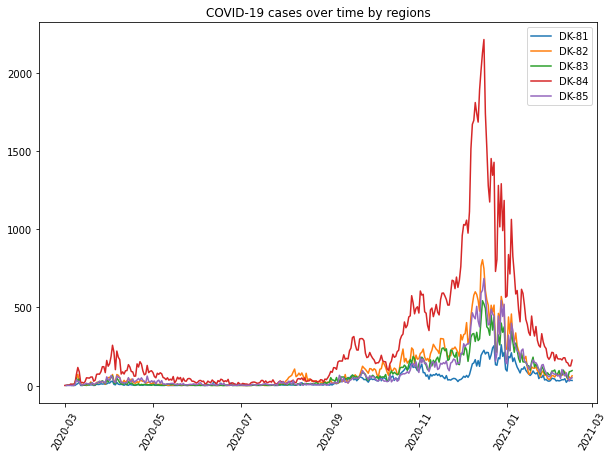

In [29]:
plt.figure(figsize=(10,7))
df_regions = merged_with_ovid.copy()
df_regions.set_index('date', inplace=True)
df_regions_1 = df_regions.groupby('iso3166-2')['confirmed_cases']
df_regions_1.plot(legend=True);
plt.xticks(rotation=60);
plt.xlabel("")
plt.title("COVID-19 cases over time by regions")

In [30]:
df_weather_dk = dk_weather.copy()
df_weather_dk["date"] = pd.to_datetime(df_weather_dk['date']).dt.date
#group by the date and take the mean of the regional values -> we're getting the mean data for the particular days in the whole of Denmark
df_weather_dk = dk_weather.groupby('date').mean() 
df_weather_dk.head()

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
date,,,,,,,
2020-02-13,86.285064,2.422044e+06,2.404600e+06,3.636417,0.001748,2.821490,4.423935
2020-02-14,87.398512,2.369072e+06,2.430333e+06,3.804369,0.000736,1.513631,2.891248
2020-02-15,91.785362,1.906938e+05,2.416947e+06,6.470372,0.006405,0.063312,7.025087
2020-02-16,88.155680,1.201935e+04,2.373562e+06,8.500593,0.014740,0.016280,9.958726
2020-02-17,79.079660,3.399493e+06,2.390946e+06,6.633759,0.001039,1.635729,10.505559


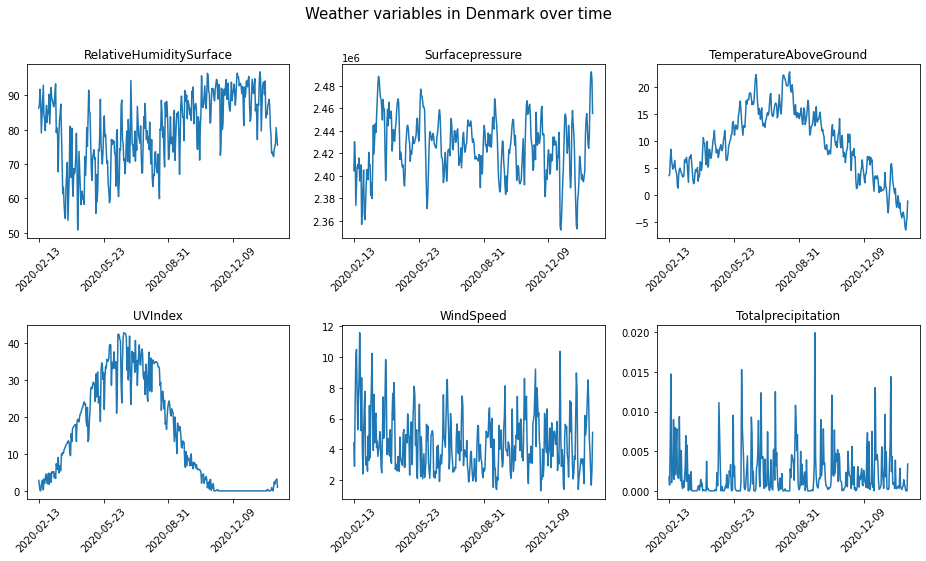

In [31]:
weather_variables = ["RelativeHumiditySurface", "Surfacepressure", "TemperatureAboveGround", "UVIndex", "WindSpeed", "Totalprecipitation"]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Weather variables in Denmark over time", fontsize = 15)

for weather_var, ax in zip(weather_variables, axs.ravel()):
    df_weather_dk[weather_var].plot(ax=ax)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(weather_var)
    

In [32]:
regions = list(df_regions['iso3166-2'].unique()) #get the 5 regions into a list
df_var_names = [] #empty, prepared to append 


#create separate dataframes for each region -> date with 4 covid variables
for region in regions:
    df_var_names.append(df_regions.loc[df_regions["iso3166-2"] == region][["hospitalized_addition", "confirmed_cases", "hospitalized_pc", "cases_pc"]])

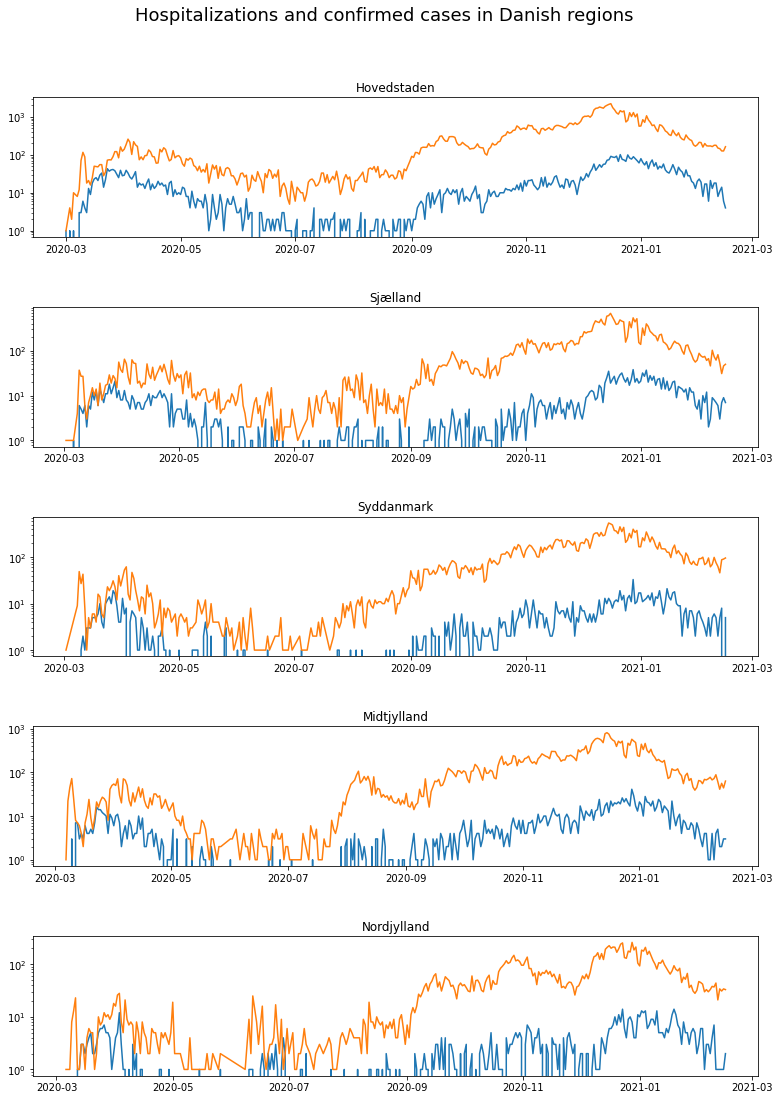

In [33]:
values = ["hospitalized_addition", "confirmed_cases"]
region_dict = {"DK-81":"Nordjylland","DK-82":"Midtjylland","DK-83":"Syddanmark","DK-84":"Hovedstaden","DK-85":"Sjælland"}

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(13, 18))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Hospitalizations and confirmed cases in Danish regions", fontsize=18, y=0.95)


for x, ax, name in zip(df_var_names, axs.ravel(), regions):
    for value in values:
        x[value].plot(ax=ax)
        ax.set_yscale('log')
        ax.set_title(region_dict[name])
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=0)


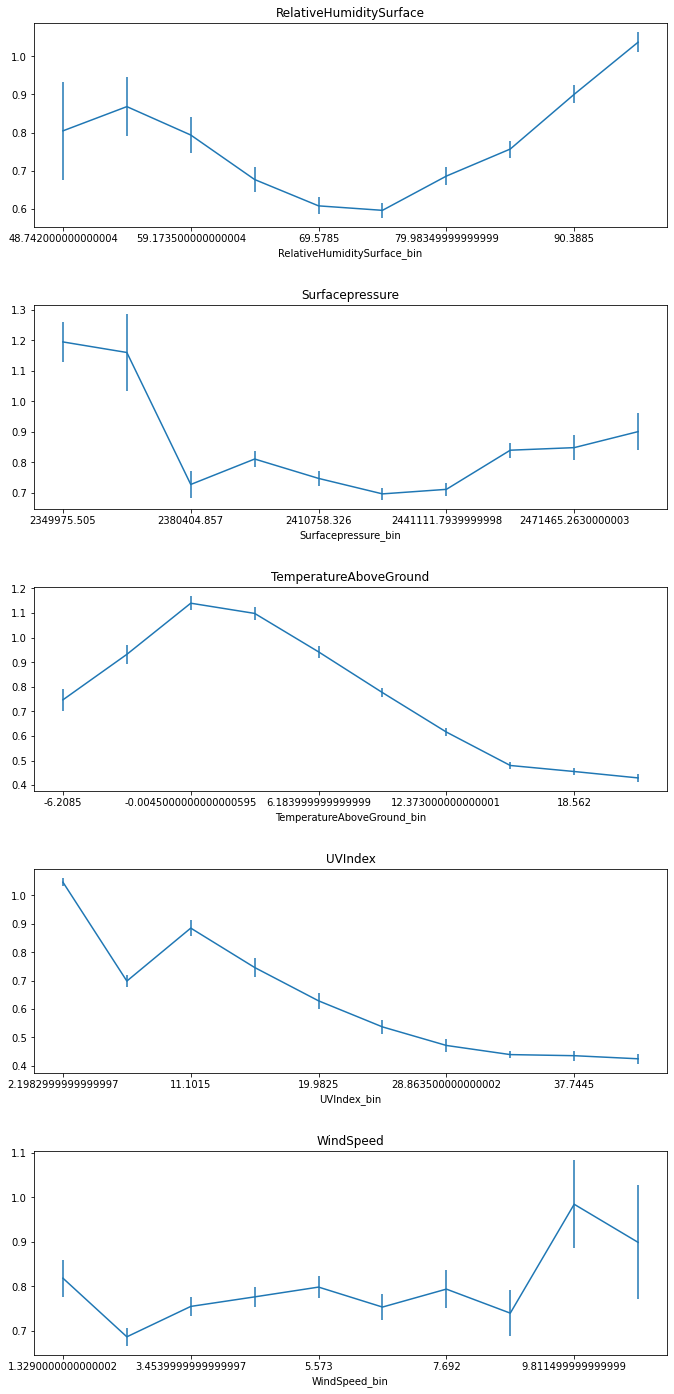

In [34]:
#NOT WORKING
weather_vars = ["RelativeHumiditySurface", "Surfacepressure", "TemperatureAboveGround", "UVIndex", "WindSpeed"]

merged_with_ovid['log_hospitalized_addition'] = np.log10(merged_with_ovid['hospitalized_addition'] + 2)

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for i in range(len(weather_vars)):
    merged_with_ovid[f"{weather_vars[i]}_bin"] = pd.cut(merged_with_ovid[weather_vars[i]], 10).apply(lambda x: x.mid)
    _ = merged_with_ovid.groupby(by = f"{weather_vars[i]}_bin")["log_hospitalized_addition"].agg(["mean", "sem"]).reset_index()
    _.plot(y = "mean", yerr = "sem", x = f"{weather_vars[i]}_bin", kind = "line", ax = ax[i], legend = False)
    ax[i].set_title(weather_vars[i])
    fig.tight_layout(pad=3.0)

In [35]:
m_covid_cases_pc = folium.Map(location = [56, 10], zoom_start = 6)

folium.Choropleth(
    geo_data = geo_json_path, #path to the geojson
    name = 'cases', #name of the layer
    data = corona_df_by_region, #dataframe containing the data
    columns = ["iso3166-2", "hospitalized_pc"], #columns that we want to focus on
    key_on = "properties.iso_3166_2", #iso code from the geoJSON (mapping the data with the corresponding geometry)
    fill_color = "OrRd", #color map
    fill_opacity = 0.7, #allows us to see the map underneath
    line_opacity = 0.2,
    legend_name = "COVID-19 cases per capita", #title
).add_to(m_covid_cases_pc)
    
m_covid_cases_pc

Text(0.5, 1.0, 'Relationship between the UV Index and the number of COVID-related hospitalizations')

<Figure size 936x1296 with 0 Axes>

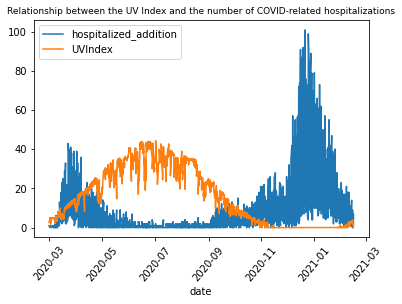

In [36]:
fig = plt.figure(figsize=(13, 18))
UV_covid = merged_with_ovid.copy()
UV_covid.set_index('date', inplace=True)
UV_covid[["hospitalized_addition", "UVIndex"]].plot()
plt.xticks(rotation=50);
plt.title("Relationship between the UV Index and the number of COVID-related hospitalizations", fontsize = 9)

<Figure size 936x1296 with 0 Axes>

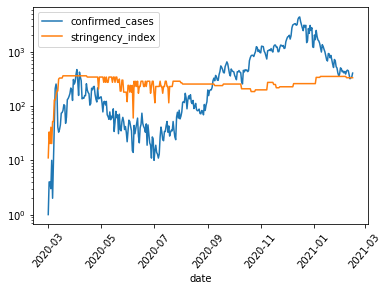

In [37]:
restrictions_df = merged_with_ovid[['date', "hospitalized_addition", "hospitalized_pc", "confirmed_cases", "cases_pc", "stringency_index"]]
restrictions_df = restrictions_df.groupby(by = "date").sum()

fig = plt.figure(figsize=(13, 18))
restrictions_df[["confirmed_cases", "stringency_index"]].plot()
plt.yscale("log") 
plt.xticks(rotation=50);

In [38]:
analysis = sm.OLS(np.log(merged_with_ovid["cases_pc"] + 1), merged_with_ovid[Xs], hasconst = True).fit(cov_type = "cluster", cov_kwds = {"groups": merged_with_ovid["iso3166-2"]}, use_t = True)
print(analysis.summary())

                            OLS Regression Results                            
Dep. Variable:               cases_pc   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     641.1
Date:                Fri, 04 Mar 2022   Prob (F-statistic):           7.27e-06
Time:                        11:25:59   Log-Likelihood:                 12750.
No. Observations:                1663   AIC:                        -2.548e+04
Df Residuals:                    1651   BIC:                        -2.541e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  4

In [39]:
#try to fix the function that we couldn't fix (it's all uncommented up there) on 5 variables and 10 bins (w/out the variable that N/As) ->DONE
#up if u don't get it to work -> remove it -> NOT NECESSARY
#maybe look if we can get the log file from deepnote -> looked for half an hour for something like this, could not find anything
#run the regression on a stringency index (it's gonna be a shit result but that's fine cause that's what we wanna prove -> that it has no effect)
#make the notebook look a little prettier

In [40]:
restrictions_df

,hospitalized_addition,hospitalized_pc,confirmed_cases,cases_pc,stringency_index
date,,,,,
2020-03-01,1,5.417051e-07,1,5.417051e-07,11.11
2020-03-02,0,0.000000e+00,4,3.095232e-06,33.33
2020-03-03,1,5.417051e-07,4,2.166820e-06,20.37
2020-03-04,0,0.000000e+00,3,2.277641e-06,40.74
2020-03-05,1,5.417051e-07,10,5.417051e-06,20.37
...,...,...,...,...,...
2021-02-11,22,1.859908e-05,377,3.122793e-04,333.35
2021-02-12,22,1.683241e-05,319,2.679962e-04,333.35
2021-02-13,32,2.568723e-05,332,2.719936e-04,333.35


In [ ]:
restrictions_df = restrictions_df.reset_index()

Text(0, 0.5, 'Stringency Index')

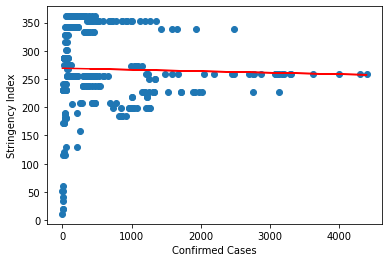

In [50]:
X = restrictions_df.loc[:, "confirmed_cases"].values.reshape(-1, 1)  # values converts it into a numpy array
Y = restrictions_df.loc[:, "stringency_index"].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions



plt.scatter(X,Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel("Confirmed Cases")
plt.ylabel("Stringency Index")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f0202db8-33cb-4a24-98d9-6e30c5d2a080' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>